In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime

In [2]:
# working with category data from cap2
cat_prod = pd.read_pickle('../../data/ecommerce/prod_with_cat.pkl', compression='zip')
uni_prod = pd.read_pickle('../../data/ecommerce/prod_unique.pkl', compression='zip')
print(cat_prod.shape, uni_prod.shape)

(788214, 2) (417053, 1)


In [3]:
cat_prod.head()

,itemid,value
15,8921,1188
70,122405,769
162,225336,491
182,193256,1261
257,301841,1493


In [11]:
cat_prod[cat_prod['itemid'] == 301841]

,itemid,value
257,301841,1493


In [10]:
cat_prod['itemid'].nunique(), cat_prod['value'].nunique()

(417053, 1242)

In [19]:
# value column is text, convert to int
cat_prod['value'] = cat_prod['value'].astype('int32')
cat_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788214 entries, 15 to 10999994
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   itemid  788214 non-null  int64
 1   value   788214 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 15.0 MB


In [39]:
# rename value to category
# DF of lists of itemid associated with category #

cat_prod.rename(columns={'value':'category'}, inplace=True)
dfcatlist = cat_prod.groupby("category").agg(list)

In [36]:
# len(dfcatlist['itemid'][0])  # len of 1st list is 159
dfcatlist['itemidcount'] = dfcatlist['itemid'].apply(len)
dfcatlist.head()

,itemid,itemidcount
category,,
0,"[263866, 229245, 23611, 304596, 311126, 62214,...",159
1,"[175802, 115073, 279462, 55796, 263477, 176579...",867
2,"[63826, 492, 48917, 63826, 492, 48917, 63826, ...",188
3,"[463944, 454913, 102096, 18871, 382319, 286334...",402
4,"[248096, 331443, 283204, 1117, 9419, 448921, 4...",77


In [58]:
# move onto dfevents because cat DF is ready
dfevents = pd.read_csv('../../data/ecommerce/events.csv')
dfevents.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [59]:
def unix_time_convert(df):
    """convert from unix time format"""
    times=[]
    for i in df['timestamp']:
        times.append(datetime.datetime.fromtimestamp(i//1000.0))
    df['timestamp']=times
    return df

In [60]:
dfevents = unix_time_convert(dfevents)

In [52]:
# category has NaN after the join
# astype to int wont work on NaN
# code below was used for testing
# dfcat = dfevents.join(cat_prod.set_index('itemid'), on='itemid')
# dfcat['category'] = dfcat['category'].fillna(-1)
# dfcat['category'] = dfcat['category'].astype('int32')
# dfcat = dfcat[dfcat['event'] == 'transaction']
# dfcat.head()

In [72]:
def join_cat(dfevents, cat_prod):
    """join category column to events DF
    also filter dfevents first for transactions"""
    dfevents = dfevents[dfevents['event'] == 'transaction']
    dfcat = dfevents.join(cat_prod.set_index('itemid'), on='itemid')
    dfcat['category'] = dfcat['category'].fillna(-1)
    dfcat['category'] = dfcat['category'].astype('int32')
    # 23838 - 22547 = 1291 extra records from items with 2 categories
    return dfcat.drop_duplicates()

In [193]:
dfcat = join_cat(dfevents, cat_prod)
print(dfcat.shape)
dfcat.head(3)

(23838, 6)


,timestamp,visitorid,event,itemid,transactionid,category
130,2015-06-01 23:17:56,599528,transaction,356475,4000.0,386
304,2015-06-01 15:18:20,121688,transaction,15335,11117.0,1098
418,2015-06-01 15:25:15,552148,transaction,81345,5444.0,1393


In [70]:
# dfevents[dfevents['event'] == 'transaction'].shape  # 22547
dfcat.drop_duplicates().shape   # 23838
# 23838 - 22547 = 1291

(23838, 6)

In [71]:
# so why is the joined DF longer now??
# perhaps transaction events are being duplicated
# check index 2754886 to see duplicates
# dfcat.index.duplicated
dfcat[dfcat.index == 2754886].drop_duplicates()

,timestamp,visitorid,event,itemid,transactionid,category
2754886,2015-07-31 13:26:38,972757,transaction,418693,1702.0,774
2754886,2015-07-31 13:26:38,972757,transaction,418693,1702.0,238


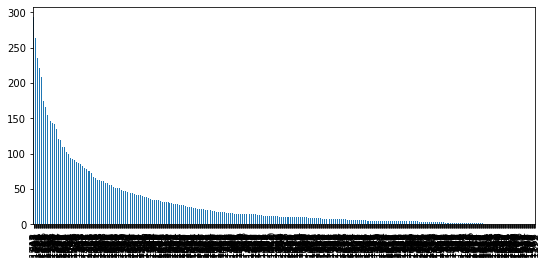

In [97]:
# dfcat['category'].value_counts().plot(kind='hist', bins=20, log=False)
dfcat['category'].value_counts()[5:].plot(kind='bar', figsize=(9,4))

In [111]:
dfcat['category'].nunique()  # 752 out of 1242
top6cat = list(dfcat['category'].value_counts().index[[0,1,3,4,5,6]])
dfcat['category'].value_counts()[:10]

,timestamp,visitorid,event,itemid,transactionid,category
1465072,2015-05-02 21:27:21,869008,transaction,40685,9765.0,1542
1463096,2015-05-02 21:35:01,345781,transaction,438400,1016.0,-1
1464289,2015-05-02 22:01:47,586756,transaction,440917,10942.0,1415
1463462,2015-05-02 22:07:38,435495,transaction,175893,6173.0,1244
1464041,2015-05-02 22:31:14,266417,transaction,301359,12546.0,470


In [208]:
def cat2day(dfcat, cat_int, fb=False):
    """takes dfcat 23838 and outputs daily purchases DF
    cat_int to only count that category
    """
    # filter category
    dfcat = dfcat[dfcat['category'] == cat_int].sort_values('timestamp')
    # rename for working with FB prophet
    dfcat.rename(columns={'timestamp':'ds'}, inplace=True)
    dfcat.rename(columns={'event':'y'}, inplace=True)
    # select columns for easier AGG
#     col_sel = ['ds', 'visitorid', 'itemid', 'category', 'event']
    col_sel = ['ds', 'y', 'category']
    dfcat = dfcat[col_sel]
    
    # resample to daily frequency and count transactions
    dfday = dfcat.resample('D', on="ds").count()
    # reset category to be correct
    dfday['category'] = cat_int    
    # make and join 139 df to pad missing head and tail
    dr = pd.date_range(start='2015-05-02', end='2015-09-17', freq='D')
    dfmake = pd.DataFrame(index=dr)
    dfmake = dfmake.join(dfday)
    dfmake['category'] = cat_int
    dfmake['y'] = dfmake['y'].fillna(0)
    dfmake['ds'] = dfmake['ds'].fillna(0)
    dfmake = dfmake.astype('int32')

    if fb:  # make ds, y format for FB
        dfmake = dfmake[['y']].reset_index().rename(columns={'index': 'ds'})

    # remove partial days ( from 139 rows to 137 )
    dfmake = dfmake.iloc[1:-1]
    return dfmake

In [222]:
for cat in top6cat:
    dftest = cat2day(dfcat, cat)
    num_zero = dftest[dftest['y'] == 0].shape[0]
    print(cat, dftest.shape, num_zero)
# tested because was at first cutting off days at beginning and end

959 (137, 3) 5
1051 (137, 3) 5
1483 (137, 3) 14
196 (137, 3) 26
1542 (137, 3) 26
618 (137, 3) 35


In [211]:
# 2015-05-02 first date in events
# 2015-09-17 last date in events
dftest = cat2day(dfcat, 1483, fb=True)
print(dftest.shape)
dftest.head(2)

(137, 2)


,ds,y
1,2015-05-03,5
2,2015-05-04,12


In [116]:
dfcat.sort_values('timestamp')[:3]

,timestamp,visitorid,event,itemid,transactionid,category
1465072,2015-05-02 21:27:21,869008,transaction,40685,9765.0,1542
1463096,2015-05-02 21:35:01,345781,transaction,438400,1016.0,-1
1464289,2015-05-02 22:01:47,586756,transaction,440917,10942.0,1415


In [117]:
dfcat.sort_values('timestamp')[-3:]

,timestamp,visitorid,event,itemid,transactionid,category
1462449,2015-09-17 20:08:16,152963,transaction,122984,5772.0,1493
1456772,2015-09-17 20:38:18,152963,transaction,362697,5670.0,1663
1454084,2015-09-17 20:43:12,152963,transaction,21970,8904.0,1051


In [160]:
    # example
    # df.groupby(['name', pd.Grouper(key='date', freq='M')])['ext price'].sum()

In [171]:
fancy = dfcat.groupby(['category', pd.Grouper(key='timestamp', 
                                              freq="D")])['event'].count()
fancy.tail()  # fancy is a series

category  timestamp 
1694      2015-09-01    1
          2015-09-07    1
          2015-09-09    2
          2015-09-10    3
          2015-09-14    1
Name: event, dtype: int64

In [172]:
# 1483
# mask = fancy.loc[['category']] == 1483
print(fancy.index.names)
type(fancy.xs(1483))  # xs selects a series
len(fancy.xs(1483))
fancy.xs(1483).index[0]
# series is still to short. this doesn't help me :((((

['category', 'timestamp']


Timestamp('2015-05-03 00:00:00')

In [176]:
# 2015-05-02 first date in events
# 2015-09-17 last date in events
dr = pd.date_range(start='2015-05-02', end='2015-09-17', freq='D') # size is 139
dr

DatetimeIndex(['2015-05-02', '2015-05-03', '2015-05-04', '2015-05-05',
               '2015-05-06', '2015-05-07', '2015-05-08', '2015-05-09',
               '2015-05-10', '2015-05-11',
               ...
               '2015-09-08', '2015-09-09', '2015-09-10', '2015-09-11',
               '2015-09-12', '2015-09-13', '2015-09-14', '2015-09-15',
               '2015-09-16', '2015-09-17'],
              dtype='datetime64[ns]', length=139, freq='D')

In [181]:
dftest.head(2)

,ds,category,y
ds,,,
2015-05-03,2,618,2
2015-05-04,3,618,3


In [192]:
dfmake = pd.DataFrame(index=dr)
# dfcat = dfevents.join(cat_prod.set_index('itemid'), on='itemid')
dfmake = dfmake.join(dftest)
dfmake['category'] = dfmake['category'].fillna(618)
dfmake['y'] = dfmake['y'].fillna(0)
dfmake['ds'] = dfmake['ds'].fillna(0)
dfmake = dfmake.astype('int32')
dfmake

,ds,y,category
2015-05-02,0,0,618
2015-05-03,0,0,618
2015-05-04,12,12,1483
2015-05-05,7,7,1483
2015-05-06,12,12,1483
...,...,...,...
2015-09-13,2,2,1483
2015-09-14,6,6,1483
2015-09-15,2,2,1483
2015-09-16,0,0,618


In [186]:
dfmake[['y']].reset_index().rename(columns={'index': 'ds'})

,ds,y
0,2015-05-02,0
1,2015-05-03,2
2,2015-05-04,3
3,2015-05-05,5
4,2015-05-06,7
...,...,...
134,2015-09-13,0
135,2015-09-14,4
136,2015-09-15,3
137,2015-09-16,2


In [221]:
dftest[dftest['y'] == 0].shape

(35, 3)